# 0. Import Library

In [51]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
# Setup ImageDataGenerator untuk load gambar dari dataframe
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Confusion Matrix dan Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

# 1. Load Dataset

In [52]:
dataset_path = "dataset"
folder_klepon = os.path.join(dataset_path, "klepon")
folder_putu   = os.path.join(dataset_path, "Putu")

count_klepon = len(os.listdir(folder_klepon))
count_putu   = len(os.listdir(folder_putu))
total = count_klepon + count_putu

print(f"Jumlah gambar klepon: {count_klepon}")
print(f"Jumlah gambar putu  : {count_putu}")
print(f"Total gambar         : {total}")

Jumlah gambar klepon: 500
Jumlah gambar putu  : 500
Total gambar         : 1000


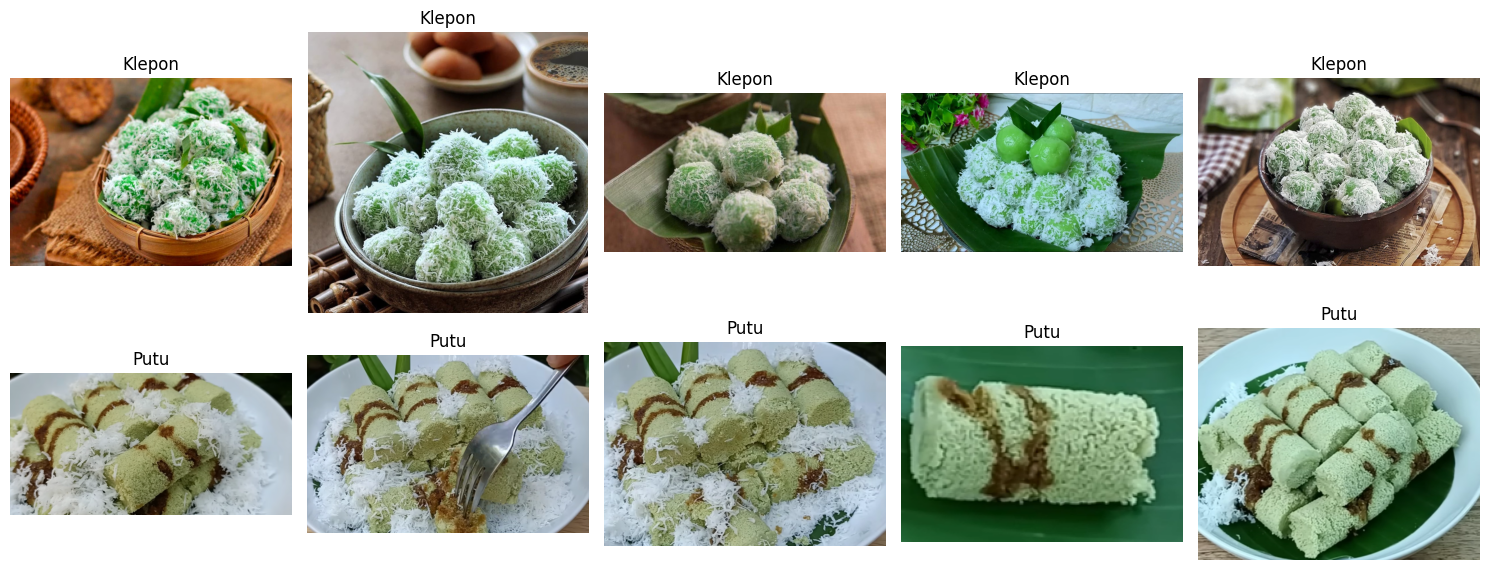

In [53]:
# Ambil list file
klepon_files = sorted(os.listdir(folder_klepon))[:5]
putu_files = sorted(os.listdir(folder_putu))[:5]

# Total gambar = 10 → 2 baris × 5 kolom
plt.figure(figsize=(15, 6))

# --- Gambar Klepon ---
for i, fname in enumerate(klepon_files):
    img_path = os.path.join(folder_klepon, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Klepon")
    plt.axis("off")

# --- Gambar Putu ---
for i, fname in enumerate(putu_files):
    img_path = os.path.join(folder_putu, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(img)
    plt.title("Putu")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 2. Load Data dari CSV dan Preprocessing

In [54]:
# Load metadata CSV
df = pd.read_csv("metadata.csv")

print(f"Total data: {len(df)}")
print(f"\nDistribusi label:")
print(df['label'].value_counts())
print(f"\nContoh 5 data pertama:")
print(df.head())

Total data: 1000

Distribusi label:
label
0    500
1    500
Name: count, dtype: int64

Contoh 5 data pertama:
                           path  label
0  dataset\klepon\01_klepon.jpg      0
1  dataset\klepon\02_klepon.jpg      0
2  dataset\klepon\03_klepon.jpg      0
3  dataset\klepon\04_klepon.jpg      0
4  dataset\klepon\05_klepon.jpg      0


In [55]:
# Split data: 70% train, 15% validation, 15% test
# Dengan stratified split untuk memastikan distribusi seimbang

# Step 1: Split 70% train dan 30% temp (untuk val + test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

# Step 2: Split 30% temp menjadi 15% validation dan 15% test (50-50 dari temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Konversi label integer menjadi string untuk compatibility dengan flow_from_dataframe
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print(f"Total data: {len(df)}")
print(f"\nData training   : {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Data validation : {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Data testing    : {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\n{'='*50}")
print("Distribusi Label Training:")
print(train_df['label'].value_counts().sort_index())
print(f"\nDistribusi Label Validation:")
print(val_df['label'].value_counts().sort_index())
print(f"\nDistribusi Label Testing:")
print(test_df['label'].value_counts().sort_index())

Total data: 1000

Data training   : 700 (70.0%)
Data validation : 150 (15.0%)
Data testing    : 150 (15.0%)

Distribusi Label Training:
label
0    350
1    350
Name: count, dtype: int64

Distribusi Label Validation:
label
0    75
1    75
Name: count, dtype: int64

Distribusi Label Testing:
label
0    75
1    75
Name: count, dtype: int64


In [56]:
IMG_SIZE = 128
BATCH_SIZE = 32

# Generator untuk training (dengan rescaling)
train_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk validation (hanya rescaling, tanpa augmentasi)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk testing (hanya rescaling, tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generator dari dataframe - TRAINING
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Create generator dari dataframe - VALIDATION
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Create generator dari dataframe - TESTING
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 700 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


# 3. Eksperimen dengan 5 Konfigurasi Model

Membandingkan 5 konfigurasi berbeda:
1. **CNN Dasar (Baseline)** - Model sederhana 2 Conv blocks
2. **CNN + Augmentasi Data** - Menambahkan data augmentation
3. **Arsitektur Lebih Dalam (VGG-like)** - Lebih banyak layer konvolusi
4. **Transfer Learning (MobileNetV2)** - Menggunakan MobileNetV2 pretrained
5. **Transfer Learning (ResNet50)** - Menggunakan ResNet50 pretrained

Semua model menggunakan **Early Stopping** untuk efisiensi training.

In [57]:
# Dictionary untuk menyimpan semua hasil eksperimen
experiment_results = {}

# Setup Early Stopping untuk semua eksperimen
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

EPOCHS_EXP = 50  # Max epochs, tapi akan stop early jika tidak ada improvement

## 3.1. Konfigurasi 1 - CNN Dasar (Baseline)

Model sederhana dengan 2 Conv blocks.

In [58]:
print("="*60)
print("KONFIGURASI 1: CNN Dasar (Baseline)")
print("="*60)

# Build model
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training dengan Early Stopping
history_1 = model_1.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_1, test_acc_1 = model_1.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['Config 1: CNN Dasar'] = {
    'history': history_1,
    'test_loss': test_loss_1,
    'test_accuracy': test_acc_1,
    'model': model_1
}

print(f"\nHasil Test - Config 1:")
print(f"Test Loss: {test_loss_1:.4f}")
print(f"Test Accuracy: {test_acc_1:.4f} ({test_acc_1*100:.2f}%)")

KONFIGURASI 1: CNN Dasar (Baseline)
Epoch 1/50
Epoch 1/50
22/22 [==============================] - 10s 395ms/step - loss: 1.4248 - accuracy: 0.4957 - val_loss: 0.6873 - val_accuracy: 0.5067
Epoch 2/50
Epoch 2/50
22/22 [==============================] - 7s 308ms/step - loss: 0.6569 - accuracy: 0.6057 - val_loss: 0.6234 - val_accuracy: 0.7133
Epoch 3/50
Epoch 3/50
22/22 [==============================] - 7s 316ms/step - loss: 0.4887 - accuracy: 0.7786 - val_loss: 0.5073 - val_accuracy: 0.7467
Epoch 4/50
22/22 [==============================] - 7s 316ms/step - loss: 0.4887 - accuracy: 0.7786 - val_loss: 0.5073 - val_accuracy: 0.7467
Epoch 4/50
22/22 [==============================] - 5s 215ms/step - loss: 0.3109 - accuracy: 0.8786 - val_loss: 0.4984 - val_accuracy: 0.8000
Epoch 5/50
Epoch 5/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1736 - accuracy: 0.9486 - val_loss: 0.5092 - val_accuracy: 0.8200
Epoch 6/50
22/22 [==============================] - 5s 217ms/step -

## 3.2. Konfigurasi 2 - CNN + Augmentasi Data

Menambahkan data augmentation untuk meningkatkan generalisasi.

In [59]:
print("="*60)
print("KONFIGURASI 2: CNN + Augmentasi Data")
print("="*60)

# Data Generator dengan Augmentasi
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator_aug = train_datagen_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Build model (sama dengan config 1)
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training dengan Early Stopping
history_2 = model_2.fit(
    train_generator_aug,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_2, test_acc_2 = model_2.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['Config 2: CNN + Augmentasi'] = {
    'history': history_2,
    'test_loss': test_loss_2,
    'test_accuracy': test_acc_2,
    'model': model_2
}

print(f"\nHasil Test - Config 2:")
print(f"Test Loss: {test_loss_2:.4f}")
print(f"Test Accuracy: {test_acc_2:.4f} ({test_acc_2*100:.2f}%)")

KONFIGURASI 2: CNN + Augmentasi Data
Found 700 validated image filenames belonging to 2 classes.
Epoch 1/50
Epoch 1/50
22/22 [==============================] - 7s 274ms/step - loss: 0.9427 - accuracy: 0.4914 - val_loss: 0.6899 - val_accuracy: 0.5267
Epoch 2/50
22/22 [==============================] - 7s 274ms/step - loss: 0.9427 - accuracy: 0.4914 - val_loss: 0.6899 - val_accuracy: 0.5267
Epoch 2/50
22/22 [==============================] - 6s 283ms/step - loss: 0.6826 - accuracy: 0.5943 - val_loss: 0.6613 - val_accuracy: 0.6133
Epoch 3/50
Epoch 3/50
22/22 [==============================] - 6s 271ms/step - loss: 0.6441 - accuracy: 0.6257 - val_loss: 0.6318 - val_accuracy: 0.6733
Epoch 4/50
22/22 [==============================] - 6s 271ms/step - loss: 0.6441 - accuracy: 0.6257 - val_loss: 0.6318 - val_accuracy: 0.6733
Epoch 4/50
22/22 [==============================] - 6s 281ms/step - loss: 0.5849 - accuracy: 0.6986 - val_loss: 0.7021 - val_accuracy: 0.6200
Epoch 5/50
Epoch 5/50
22/22 [

## 3.3. Konfigurasi 3 - Arsitektur Lebih Dalam (VGG-like)

Model dengan lebih banyak layer konvolusi untuk ekstraksi fitur yang lebih kompleks.

In [60]:
print("="*60)
print("KONFIGURASI 3: Arsitektur Lebih Dalam (VGG-like)")
print("="*60)

# Build model VGG-like (lebih dalam)
model_3 = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Fully Connected
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_3.count_params():,}")

# Training dengan Early Stopping
history_3 = model_3.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_3, test_acc_3 = model_3.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['Config 3: VGG-like'] = {
    'history': history_3,
    'test_loss': test_loss_3,
    'test_accuracy': test_acc_3,
    'model': model_3
}

print(f"\nHasil Test - Config 3:")
print(f"Test Loss: {test_loss_3:.4f}")
print(f"Test Accuracy: {test_acc_3:.4f} ({test_acc_3*100:.2f}%)")

KONFIGURASI 3: Arsitektur Lebih Dalam (VGG-like)
Total parameters: 8,709,026
Epoch 1/50
Epoch 1/50
22/22 [==============================] - 8s 307ms/step - loss: 0.7235 - accuracy: 0.5086 - val_loss: 0.6861 - val_accuracy: 0.6333
Epoch 2/50
Epoch 2/50
22/22 [==============================] - 7s 297ms/step - loss: 0.6824 - accuracy: 0.5786 - val_loss: 0.6771 - val_accuracy: 0.5600
Epoch 3/50
22/22 [==============================] - 7s 297ms/step - loss: 0.6824 - accuracy: 0.5786 - val_loss: 0.6771 - val_accuracy: 0.5600
Epoch 3/50
22/22 [==============================] - 7s 308ms/step - loss: 0.6407 - accuracy: 0.6529 - val_loss: 0.6474 - val_accuracy: 0.6333
Epoch 4/50
22/22 [==============================] - 7s 308ms/step - loss: 0.6407 - accuracy: 0.6529 - val_loss: 0.6474 - val_accuracy: 0.6333
Epoch 4/50
22/22 [==============================] - 6s 279ms/step - loss: 0.5591 - accuracy: 0.7114 - val_loss: 0.5738 - val_accuracy: 0.7267
Epoch 5/50
Epoch 5/50
22/22 [====================

## 3.4. Konfigurasi 4 - Transfer Learning (MobileNetV2)

Menggunakan model pretrained MobileNetV2 untuk feature extraction.

In [62]:
print("="*60)
print("KONFIGURASI 4: Transfer Learning (MobileNetV2)")
print("="*60)

# Load pretrained MobileNetV2
base_model_mobilenet = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model_mobilenet.trainable = False

# Build model
model_4 = Sequential([
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_4.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_4.trainable_weights]):,}")

# Training dengan Early Stopping
history_4 = model_4.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_4, test_acc_4 = model_4.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['Config 4: MobileNetV2'] = {
    'history': history_4,
    'test_loss': test_loss_4,
    'test_accuracy': test_acc_4,
    'model': model_4
}

print(f"\nHasil Test - Config 4:")
print(f"Test Loss: {test_loss_4:.4f}")
print(f"Test Accuracy: {test_acc_4:.4f} ({test_acc_4*100:.2f}%)")

KONFIGURASI 4: Transfer Learning (MobileNetV2)
Total parameters: 2,422,210
Trainable parameters: 164,226
Total parameters: 2,422,210
Trainable parameters: 164,226
Epoch 1/50
Epoch 1/50
22/22 [==============================] - 9s 243ms/step - loss: 0.5835 - accuracy: 0.7429 - val_loss: 0.2140 - val_accuracy: 0.9133
Epoch 2/50
22/22 [==============================] - 9s 243ms/step - loss: 0.5835 - accuracy: 0.7429 - val_loss: 0.2140 - val_accuracy: 0.9133
Epoch 2/50
22/22 [==============================] - 5s 214ms/step - loss: 0.2249 - accuracy: 0.9057 - val_loss: 0.1755 - val_accuracy: 0.9333
Epoch 3/50
22/22 [==============================] - 5s 214ms/step - loss: 0.2249 - accuracy: 0.9057 - val_loss: 0.1755 - val_accuracy: 0.9333
Epoch 3/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1449 - accuracy: 0.9443 - val_loss: 0.1451 - val_accuracy: 0.9467
Epoch 4/50
Epoch 4/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1252 - accuracy: 0.9457 - val

## 3.5. Konfigurasi 5 - Transfer Learning (ResNet50)

Menggunakan model pretrained ResNet50 untuk feature extraction.

In [63]:
print("="*60)
print("KONFIGURASI 5: Transfer Learning (ResNet50)")
print("="*60)

from tensorflow.keras.applications import ResNet50

# Load pretrained ResNet50
base_model_resnet = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model_resnet.trainable = False

# Build model
model_5 = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_5.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_5.trainable_weights]):,}")

# Training dengan Early Stopping
history_5 = model_5.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_5, test_acc_5 = model_5.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['Config 5: ResNet50'] = {
    'history': history_5,
    'test_loss': test_loss_5,
    'test_accuracy': test_acc_5,
    'model': model_5
}

print(f"\nHasil Test - Config 5:")
print(f"Test Loss: {test_loss_5:.4f}")
print(f"Test Accuracy: {test_acc_5:.4f} ({test_acc_5*100:.2f}%)")

KONFIGURASI 5: Transfer Learning (ResNet50)
94765736/94765736 [==============================] - 15s 0us/step
Total parameters: 24,145,410
Trainable parameters: 557,698
Epoch 1/50
Total parameters: 24,145,410
Trainable parameters: 557,698
Epoch 1/50
22/22 [==============================] - 8s 265ms/step - loss: 0.7734 - accuracy: 0.4957 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 2/50
22/22 [==============================] - 8s 265ms/step - loss: 0.7734 - accuracy: 0.4957 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 2/50
22/22 [==============================] - 5s 218ms/step - loss: 0.7346 - accuracy: 0.4657 - val_loss: 0.6915 - val_accuracy: 0.5067
Epoch 3/50
22/22 [==============================] - 5s 218ms/step - loss: 0.7346 - accuracy: 0.4657 - val_loss: 0.6915 - val_accuracy: 0.5067
Epoch 3/50
22/22 [==============================] - 5s 225ms/step - loss: 0.7101 - accuracy: 0.4957 - val_loss: 0.6894 - val_accuracy: 0.5133
Epoch 4/50
Epoch 4/50
22/22 [======================

## 3.6. Perbandingan Hasil Semua Konfigurasi

In [64]:
# Tabel Perbandingan Hasil
print("="*85)
print("RINGKASAN PERBANDINGAN HASIL EKSPERIMEN")
print("="*85)
print(f"{'Konfigurasi':<30} {'Test Loss':<12} {'Test Accuracy':<15} {'Epochs Run'}")
print("-"*85)

for config_name, result in experiment_results.items():
    epochs_run = len(result['history'].history['loss'])
    print(f"{config_name:<30} {result['test_loss']:<12.4f} {result['test_accuracy']*100:<15.2f}% {epochs_run}")

print("="*85)

# Cari model terbaik
best_config = max(experiment_results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\nModel Terbaik: {best_config[0]}")
print(f"   Test Accuracy: {best_config[1]['test_accuracy']*100:.2f}%")
print(f"   Test Loss: {best_config[1]['test_loss']:.4f}")

RINGKASAN PERBANDINGAN HASIL EKSPERIMEN
Konfigurasi                    Test Loss    Test Accuracy   Epochs Run
-------------------------------------------------------------------------------------
Config 1: CNN Dasar            0.4776       78.67          % 9
Config 2: CNN + Augmentasi     0.4566       79.33          % 11
Config 3: VGG-like             0.5655       79.33          % 17
Config 4: MobileNetV2          0.2355       89.33          % 8
Config 5: ResNet50             0.6739       59.33          % 29

Model Terbaik: Config 4: MobileNetV2
   Test Accuracy: 89.33%
   Test Loss: 0.2355


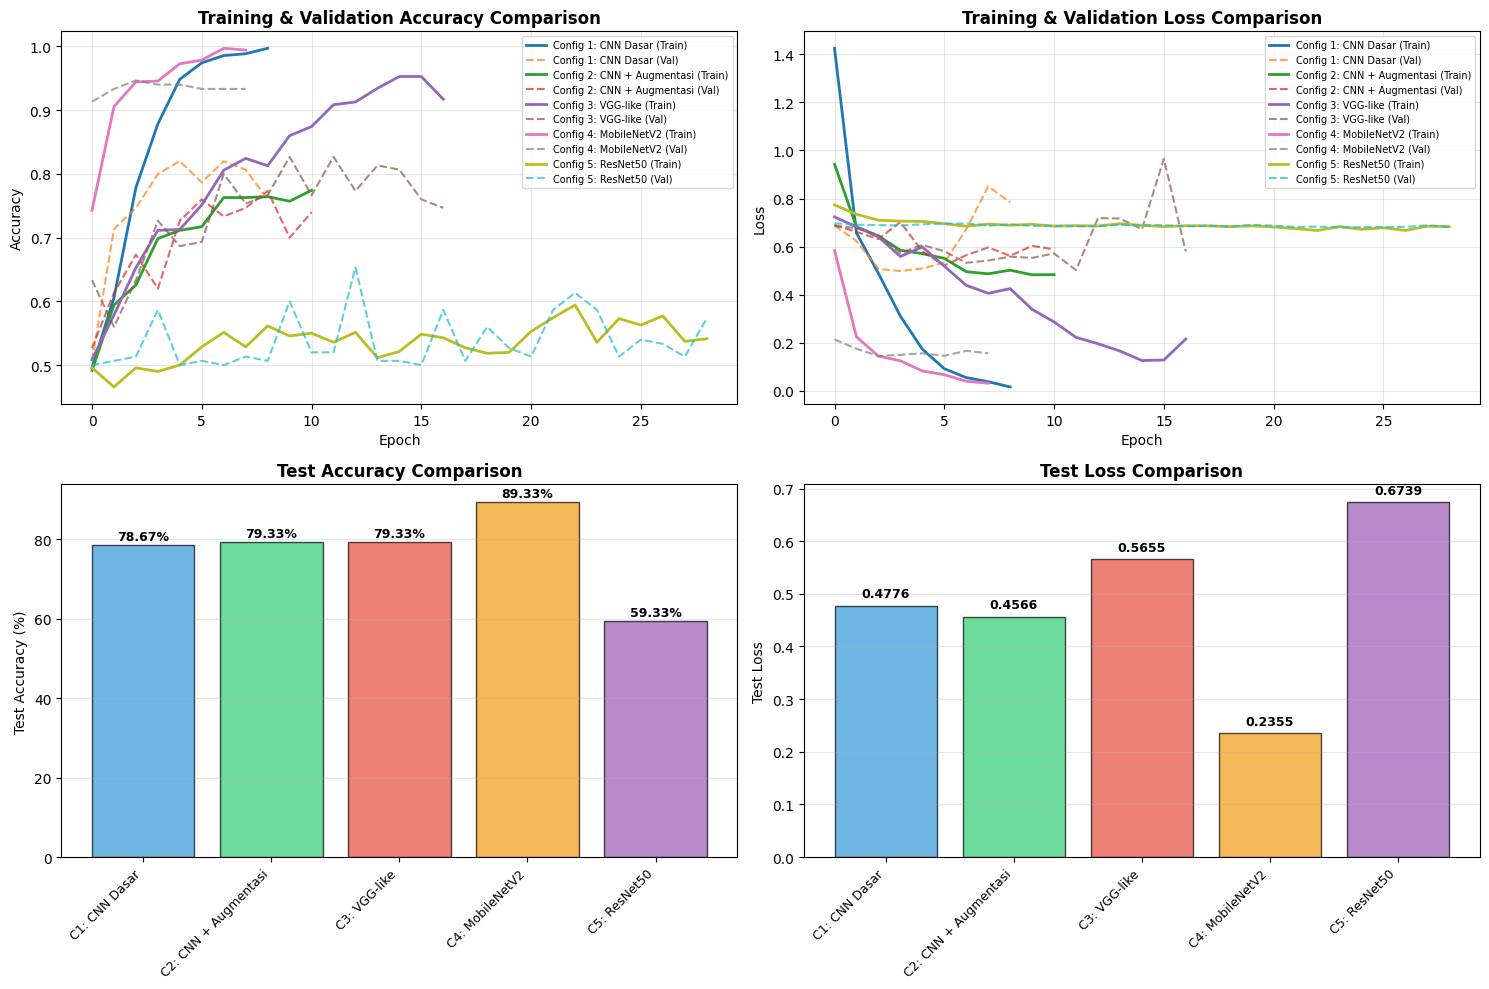

In [65]:
# Visualisasi Perbandingan - Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Accuracy
ax1 = axes[0, 0]
for config_name, result in experiment_results.items():
    history = result['history']
    ax1.plot(history.history['accuracy'], label=f"{config_name} (Train)", linestyle='-', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label=f"{config_name} (Val)", linestyle='--', alpha=0.7)

ax1.set_title('Training & Validation Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=7, loc='best')
ax1.grid(True, alpha=0.3)

# Plot Loss
ax2 = axes[0, 1]
for config_name, result in experiment_results.items():
    history = result['history']
    ax2.plot(history.history['loss'], label=f"{config_name} (Train)", linestyle='-', linewidth=2)
    ax2.plot(history.history['val_loss'], label=f"{config_name} (Val)", linestyle='--', alpha=0.7)

ax2.set_title('Training & Validation Loss Comparison', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(fontsize=7, loc='best')
ax2.grid(True, alpha=0.3)

# Bar Chart - Test Accuracy
ax3 = axes[1, 0]
configs = list(experiment_results.keys())
test_accs = [result['test_accuracy']*100 for result in experiment_results.values()]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

bars = ax3.bar(range(len(configs)), test_accs, color=colors[:len(configs)], alpha=0.7, edgecolor='black')
ax3.set_xticks(range(len(configs)))
ax3.set_xticklabels([c.replace('Config ', 'C') for c in configs], rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Test Accuracy (%)')
ax3.set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Tambahkan nilai di atas bar
for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Bar Chart - Test Loss
ax4 = axes[1, 1]
test_losses = [result['test_loss'] for result in experiment_results.values()]

bars2 = ax4.bar(range(len(configs)), test_losses, color=colors[:len(configs)], alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(configs)))
ax4.set_xticklabels([c.replace('Config ', 'C') for c in configs], rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Test Loss')
ax4.set_title('Test Loss Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Tambahkan nilai di atas bar
for i, (bar, loss) in enumerate(zip(bars2, test_losses)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{loss:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

In [66]:
# DataFrame untuk perbandingan detail
comparison_df = pd.DataFrame({
    'Konfigurasi': list(experiment_results.keys()),
    'Test Accuracy (%)': [result['test_accuracy']*100 for result in experiment_results.values()],
    'Test Loss': [result['test_loss'] for result in experiment_results.values()],
    'Epochs Run': [len(result['history'].history['loss']) for result in experiment_results.values()],
    'Final Train Acc (%)': [result['history'].history['accuracy'][-1]*100 for result in experiment_results.values()],
    'Final Val Acc (%)': [result['history'].history['val_accuracy'][-1]*100 for result in experiment_results.values()]
})

comparison_df = comparison_df.sort_values('Test Accuracy (%)', ascending=False)
print("\n" + "="*110)
print("TABEL DETAIL PERBANDINGAN KONFIGURASI (Sorted by Test Accuracy)")
print("="*110)
print(comparison_df.to_string(index=False))
print("="*110)


TABEL DETAIL PERBANDINGAN KONFIGURASI (Sorted by Test Accuracy)
               Konfigurasi  Test Accuracy (%)  Test Loss  Epochs Run  Final Train Acc (%)  Final Val Acc (%)
     Config 4: MobileNetV2          89.333332   0.235460           8            99.428570          93.333334
Config 2: CNN + Augmentasi          79.333335   0.456611          11            77.428573          74.000001
        Config 3: VGG-like          79.333335   0.565548          17            91.714287          74.666667
       Config 1: CNN Dasar          78.666669   0.477599           9            99.714285          75.999999
        Config 5: ResNet50          59.333330   0.673931          29            54.142857          57.333332


## 3.7. Evaluasi Detail Model Terbaik

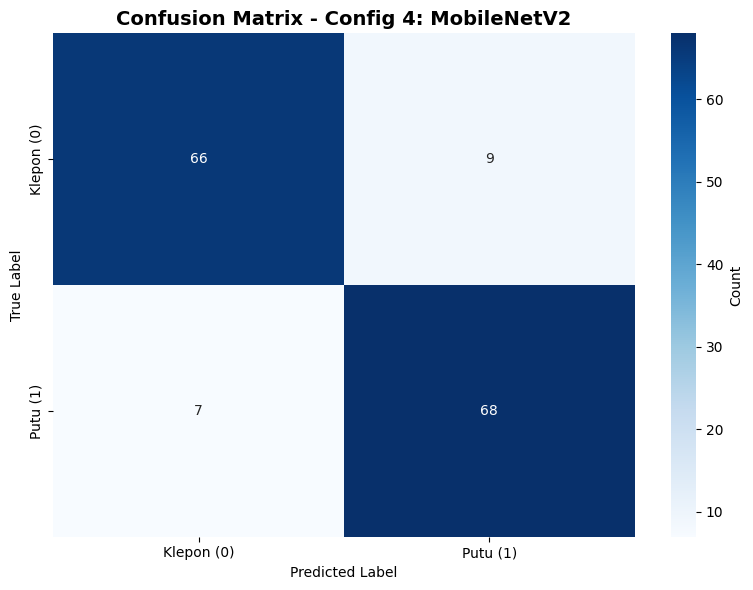


CLASSIFICATION REPORT - Config 4: MobileNetV2
              precision    recall  f1-score   support

  Klepon (0)       0.90      0.88      0.89        75
    Putu (1)       0.88      0.91      0.89        75

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



In [67]:
# Confusion Matrix dan Classification Report untuk model terbaik
best_model = best_config[1]['model']

test_generator.reset()
y_pred_probs = best_model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Klepon (0)', 'Putu (1)'], 
            yticklabels=['Klepon (0)', 'Putu (1)'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_config[0]}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*70)
print(f"CLASSIFICATION REPORT - {best_config[0]}")
print("="*70)
print(classification_report(y_true, y_pred, target_names=['Klepon (0)', 'Putu (1)']))
print("="*70)

## 3.8. Save Model Terbaik

In [69]:
# Save model terbaik
best_model_name = best_config[0].replace('Config ', '').replace(':', '').replace(' ', '_').lower()
filename = f'model_best_{best_model_name}.h5'

best_model.save(filename)
print("\n" + "="*70)
print("MODEL TERBAIK BERHASIL DISIMPAN")
print("="*70)
print(f"   Filename     : {filename}")
print(f"   Konfigurasi  : {best_config[0]}")
print(f"   Test Accuracy: {best_config[1]['test_accuracy']*100:.2f}%")
print(f"   Test Loss    : {best_config[1]['test_loss']:.4f}")
print("="*70)


MODEL TERBAIK BERHASIL DISIMPAN
   Filename     : model_best_4_mobilenetv2.h5
   Konfigurasi  : Config 4: MobileNetV2
   Test Accuracy: 89.33%
   Test Loss    : 0.2355
